<a href="https://colab.research.google.com/github/nishithewel/EMSentiment/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nishithewel/ID5059GroupProject.git

Cloning into 'ID5059GroupProject'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 308 (delta 169), reused 140 (delta 67), pack-reused 0
Receiving objects: 100% (308/308), 14.76 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [2]:
# import os 
# os.chdir('/content/ID5059GroupProject')
# ! git pull

### Downloading the Data from kaggle.

In [3]:

# !pip install -q kaggle
# from google.colab import files
# files.upload()
# !rm -rf sample_data
# !mkdir  -p /root/.kaggle/
# !mv kaggle.json  /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !ls -lart /root/.kaggle/
# !kaggle competitions download -c 'ieee-fraud-detection'
# !mkdir data
# !mv ieee-fraud-detection.zip data/
# !unzip data/ieee-fraud-detection.zip -d data/

## Introduction to the Dataset

 - Vivesh 

### Team Members
- Nishithe Welandawe - naw4
- Joseph Edwards - jde1
- Anli Hu - 373
- Yao-Ting Wang - ytw1
-


### Installs and Imports

In [4]:
! pip install imblearn 

In [5]:
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

os.chdir('/content/ID5059GroupProject')
from imblearn import over_sampling
from utils.preprocess import preprocess
from utils.reduce_memory import reduce_mem_usage
from sklearn.model_selection import train_test_split
from utils.model_stack import stack_models
from utils.diagnositics import get_diagnostics

from random import sample


### Loading the dataset

- Download the dataset from Kaggle and save it the GDrive session.
- Due to the large size, to keep loading size down we optimize data types to reduce memory usage.
- Merge the Transaction and Identity data set to create the 'Test' set.



In [6]:
### You need to change these codes to load your dataset
#if youre files are stored in google drive do this
DRIVE_STORE = True
DEBUG = True
if DRIVE_STORE == True:
  drive.mount('/content/drive') 
  root_dir = '/content/drive/MyDrive/Python/ID5059-GroupProject/ieee-fraud-detection/' #for nish
  
else:
  root_dir = '/content/data/'
os.chdir(root_dir)

if DEBUG:
  # test_iden = pd.read_csv(root_dir + 'test_identity.csv',nrows = 100)
  # test_tran = pd.read_csv(root_dir +'test_transaction.csv',nrows = 100)
  # train_iden = pd.read_csv(root_dir +'train_identity.csv',nrows = 100)
  # train_tran = pd.read_csv(root_dir +'train_transaction.csv',nrows = 100)
  test_iden = pd.read_csv(root_dir + 'test_identity.csv',)
  test_tran = pd.read_csv(root_dir +'test_transaction.csv',)
  train_iden = pd.read_csv(root_dir +'train_identity.csv',)
  train_tran = pd.read_csv(root_dir +'train_transaction.csv',)

test_tran = reduce_mem_usage(test_tran)
train_tran = reduce_mem_usage(train_tran)  

train = pd.merge(train_tran, train_iden, on = 'TransactionID', how = 'left')
test = pd.merge(test_tran, test_iden, on = 'TransactionID', how = 'left')


Mounted at /content/drive
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


We create a local test to run diagnostics. \
NB the original test dataset did not contain a target variable.

In [7]:
test_ind = sample(range(len(train)),
                        int(0.8*len(train))
                        )
#but we need a local test to run diagnostics as well
local_test = train.iloc[test_ind]
#drop rows from train
train = train.drop(test_ind,axis = 0)

del train_tran, train_iden, test_iden, test_tran

Test_dataset and train_dataset had a mismatch in the name of id features(id_x,  whereas in the test_dataset id features were of the form id-x). \

 So, we changed the format of id features in the test_dataset from id-x to id_x.

In [8]:
test.columns  = [col.replace('-','_') for col in test.columns]

## EDA
We performed basic analysis on the data.
- Visualise target variable distribution.
- Correlation - Correlation plot becomes unwieldy due to large covariate space hence is not shown for brevity.


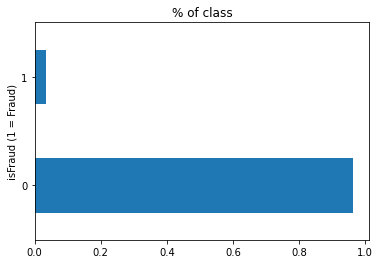

In [9]:
train['isFraud'].value_counts(normalize = True).plot(kind= 'barh')
plt.title('% of class')
plt.ylabel('isFraud (1 = Fraud)')
plt.show()

We find very few instance of Fraud. SO  we consider Class Balancing.

## Feature Preproccessing

Systematically, deal with features by considering the following,
- 'M' columns - look like true or false lets convert them to 1, 0
- 'D' columns - these are fine all numerical
- 'Card' columns - numerical except for 4,6

We deal with categorical variables using dummy vars.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118108 entries, 0 to 590538
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(14), float16(332), float32(44), float64(23), int16(1), int32(2), int8(1), object(17)
memory usage: 134.4+ MB


In [13]:
train = preprocess(train)
test = preprocess(test)
local_test = preprocess(local_test)



What features are we dropping and why?

- TransactionID - Only a unique identifier for identity
- Id Columns - All Id columns contain at least 75% NaN values 


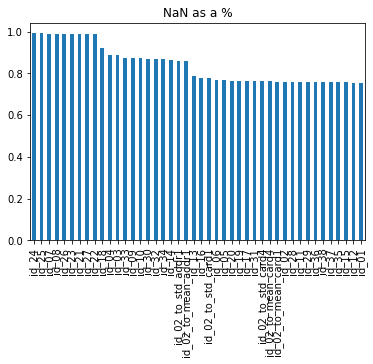

In [14]:
id_cols = [col for col in train.columns if col.startswith('id')]
df_id = train[id_cols]
# df_id.head()
nulls = df_id.isnull().sum()/len(df_id) #as a percentage
nulls.sort_values(ascending=False).plot.bar(title='NaN as a %')
# train.drop(id_cols, axis = 1,inplace = True)

In [15]:
#Run this otherwise might cause ram overflows
v_cols = [col for col in train.columns if col.startswith('V')]
# # lets ignore the v columns for the time being
train.drop(v_cols,axis =1, inplace = True)
train.drop(id_cols, axis = 1,inplace = True)
test.drop(v_cols,axis =1, inplace = True)
test.drop(id_cols, axis = 1,inplace = True)
local_test.drop(v_cols,axis =1, inplace = True)
local_test.drop(id_cols, axis = 1,inplace = True)

In [16]:
categorical_features = list(set(train.columns) - set(train._get_numeric_data().columns))
#we get dummy for some features only
dummy_cols = [ col for col in categorical_features 
                    if len(train[col].unique()) < 15]
large_cats = list(set(train.columns) - set(train._get_numeric_data()) - set(dummy_cols))

In [17]:
from sklearn.preprocessing import OneHotEncoder  #the disco import 

def dummy_transform(df,encoder,col):
  new_col = [col+'_' + str(i)  for i in encoder.categories_[0].tolist()]
  dummy_arr = encoder.transform(df[col].to_numpy().reshape(-1, 1))
  dummy_df = pd.DataFrame(dummy_arr, columns = new_col)

  # Allows nice concat-ing
  dummy_df.reset_index(drop=True, inplace=True)
  df.reset_index(drop=True, inplace=True)
  return pd.concat([df, dummy_df],axis =1)

for col in dummy_cols:
  enc = OneHotEncoder(handle_unknown='ignore',sparse=False) 
  dummy_train = enc.fit_transform(train[col].to_numpy().reshape(-1, 1))
  
  train = dummy_transform(train,enc,col)
  local_test = dummy_transform(local_test,enc,col)
  test = dummy_transform(test,enc,col)
  print('encoding',col)

train.drop(dummy_cols,axis =1,inplace = True )
test.drop(dummy_cols,axis =1,inplace = True )


encoding M4
encoding OS_id_30
encoding DeviceType
encoding M7
encoding M2
encoding device_name
encoding M3
encoding M9
encoding M6
encoding ProductCD
encoding R_emaildomain_2
encoding M8
encoding M1
encoding P_emaildomain_3
encoding P_emaildomain_2
encoding M5
encoding card4
encoding R_emaildomain_3
encoding card6


In [19]:
def frequency_encoder(x,groupby):
  if x == None:
    return groupby.get(np.nan)
  else:
    return groupby.get(x)


  # large_cats
for col in large_cats:
  freq_enc = (train.groupby(col,dropna=False  # to prevent loss of information
                            ).size()) / len(train)
  train[col+'freq'] = train[col].apply(lambda x : frequency_encoder(x,freq_enc))
  test[col+'freq'] = test[col].apply(lambda x : frequency_encoder(x,freq_enc))
  local_test[col+'freq'] = local_test[col].apply(lambda x : frequency_encoder(x,freq_enc))

train.drop(large_cats,axis = 1,inplace = True)
test.drop(large_cats,axis = 1,inplace = True)
local_test.drop(large_cats,axis = 1,inplace = True)

### Column Imputation
How are we dealing with NaN/Missing/Infinite Values?

To use SMOTE we must remove np.infs and NaNs,
- So we initially drop columns with less than 80% non-NA values.
- Then, we drop rows containing NaN values.

This using performance resulted in a higher performance on 
balanced score measures than keeping NaNs and not using SMOTE.





In [20]:
high_na = train.columns[train.isnull().sum()/len(train) > 0.2]
train_na = train.drop(high_na, axis=1)
test = test.drop(high_na, axis=1)
local_test = local_test.drop(high_na, axis=1)

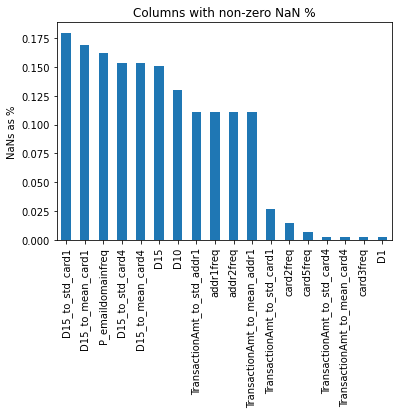

In [39]:
nulls = train_na.isnull().sum()/len(train_na) #as a percentage
nulls[nulls.values > 0].sort_values(ascending=False).plot.bar()
plt.title('Columns with non-zero NaN %')
plt.ylabel('NaNs as %')
plt.show()

train_no_na = train_na[~train_na.isin([np.nan, np.inf, -np.inf]).any(1)]

### Outlier removal
Since we are using ensemble tree methods that are robust to outliers we choose not to perform outlier removal. \
 Doing it in a feature agnostic manner would destroy information on anomalies and doing so otherwise would require pruning each column.


### Class Balancing
To perform class balancing we use SMOTE from Imbalanced Learn, to create synthetic data for the minority(isFraud = 1) class.

In [22]:

X_train, y_train = train_no_na.drop('isFraud',axis = 1), train_no_na['isFraud']

oversample = over_sampling.SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train.drop('TransactionID', axis=1, inplace = True)
X_test, y_test = local_test.drop(['isFraud', 'TransactionID'], axis = 1), local_test['isFraud']

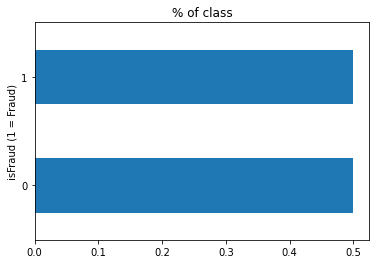

In [23]:
y_train.value_counts(normalize = True).plot(kind= 'barh')
plt.title('% of class')
plt.ylabel('isFraud (1 = Fraud)')
plt.show()

## Model Creation & Fitting


### Individiual models

In [26]:
#naw4
from sklearn.metrics import accuracy_score

import xgboost as xgb

xgb_cl = xgb.XGBClassifier(
    # tree_method='gpu_hist', gpu_id=0,
    # max_depth = 10,
    n_estimators=500,
    learning_rate = 0.01
    )
eval_set  = [(X_train, y_train), (X_test, y_test)]

xgb_cl.fit(X_train, y_train,
           eval_set = eval_set,
           eval_metric = 'auc',
          #  verbose=True,
           early_stopping_rounds=10,
           )

preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

[0]	validation_0-auc:0.877425	validation_1-auc:0.72619
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.877425	validation_1-auc:0.72619
[2]	validation_0-auc:0.877425	validation_1-auc:0.72619
[3]	validation_0-auc:0.890298	validation_1-auc:0.724303
[4]	validation_0-auc:0.890298	validation_1-auc:0.724303
[5]	validation_0-auc:0.893692	validation_1-auc:0.724303
[6]	validation_0-auc:0.890298	validation_1-auc:0.724303
[7]	validation_0-auc:0.893692	validation_1-auc:0.724303
[8]	validation_0-auc:0.893692	validation_1-auc:0.724303
[9]	validation_0-auc:0.893692	validation_1-auc:0.724303
[10]	validation_0-auc:0.893692	validation_1-auc:0.724303
Stopping. Best iteration:
[0]	validation_0-auc:0.877425	validation_1-auc:0.72619



0.7556177396958715

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV



xgb_cl = xgb.XGBClassifier(
    # tree_method='gpu_hist', gpu_id=0
    )
params = { 'max_depth': [3, 5, 10, 15],
           'learning_rate': [0.01, 0.1],
           'subsample': np.arange(0.4, 1.0, 0.2),
           'colsample_bytree': np.arange(0.4, 1.0, 0.2),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.2),
           'n_estimators': [100, 500, 1000]

          }
fit_params = {
          'early_stopping_rounds': 10,
          'eval_set' : eval_set,
          'eval_metric': 'auc',
          'verbose': True
}

clf = RandomizedSearchCV(estimator=xgb_cl,
                         param_distributions=params,
                         n_jobs = -1,
                          scoring='roc_auc',
                         n_iter=5,
                         verbose=1
                         )

search = clf.fit(X_train, y_train,**fit_params)
path = '/content/drive/MyDrive/Python/ID5059-GroupProject/'
clf.best_estimator_.save_model(path + 'optim_xgb.json')
preds_optimised = clf.predict(X_test)

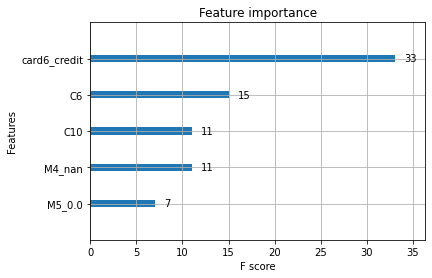

In [46]:
xgb.plot_importance(xgb_cl)
plt.show()

Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

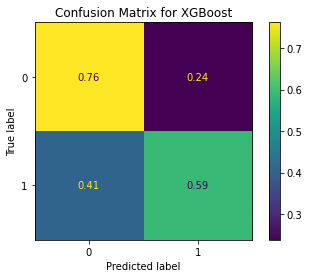

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, preds,normalize='true')
plt.title('Confusion Matrix for XGBoost')
plt.show()

In [ ]:
#jde1
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'n_estimators': [10, 20, 50, 100, 500]}
 ]

bag = BaggingClassifier(max_features=0.8, max_samples=0.8)

scores = ["precision", "roc_auc"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    bag_clf = GridSearchCV(bag,
                           param_grid,
                           scoring=score,
                           n_jobs = -1)
    bag_clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(bag_clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = bag_clf.cv_results_["mean_test_score"]
    stds = bag_clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, bag_clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

In [ ]:
preds = bag_clf.predict(X_test)
accuracy_score(y_test, preds)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds,normalize='true')
plt.title('Confusion Matrix for Bagging Classifier')

In [ ]:
! pip uninstall lightgbm -y

# install lightgbm GPU
! pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"


In [66]:
#anli
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          # 'device':'gpu',
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 5313,
         }
from sklearn.model_selection import train_test_split
score = 0

feature_importances = pd.DataFrame()

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)
lgb_clf = lgb.train(params, dtrain, 100, valid_sets = [dtrain, dvalid])

feature_importances = lgb_clf.feature_importance()

y_pred_valid = lgb_clf.predict(X_test)
score = roc_auc_score(y_test, y_pred_valid)

print(f"AUC = {score}")

[1]	training's auc: 0.990555	valid_1's auc: 0.761943
[2]	training's auc: 0.994956	valid_1's auc: 0.795775
[3]	training's auc: 0.995787	valid_1's auc: 0.811099
[4]	training's auc: 0.996077	valid_1's auc: 0.817684
[5]	training's auc: 0.996301	valid_1's auc: 0.822728
[6]	training's auc: 0.996631	valid_1's auc: 0.83397
[7]	training's auc: 0.996611	valid_1's auc: 0.832853
[8]	training's auc: 0.996759	valid_1's auc: 0.834938
[9]	training's auc: 0.996767	valid_1's auc: 0.834867
[10]	training's auc: 0.996924	valid_1's auc: 0.837217
[11]	training's auc: 0.997011	valid_1's auc: 0.838933
[12]	training's auc: 0.997113	valid_1's auc: 0.838547
[13]	training's auc: 0.997149	valid_1's auc: 0.842402
[14]	training's auc: 0.99722	valid_1's auc: 0.843425
[15]	training's auc: 0.997244	valid_1's auc: 0.843708
[16]	training's auc: 0.997364	valid_1's auc: 0.844407
[17]	training's auc: 0.99736	valid_1's auc: 0.843925
[18]	training's auc: 0.997388	valid_1's auc: 0.844544
[19]	training's auc: 0.997385	valid_1's 

In [64]:
#wonchoi

from sklearn.ensemble import RandomForestClassifier, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse

# Create a random forest regressor model with the best hyperparameter fits 
rf_final = RandomForestClassifier(n_estimators = 90, max_depth = 5, n_jobs = -1, 
                                 oob_score = True, random_state = 30801)
rf_final = rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_train)

# Calculate its rmse to compare with the previous model
res_rmse = mse(y_train, y_pred, squared = True)

# Calculate its oob score
res_oob = rf_final.oob_score_
print('Root mean squared error:', 
      res_rmse,'Out of box score of final model: ', res_oob)

Root mean squared error: 0.07495648225232725 Out of box score of final model:  0.9218723983955196


In [ ]:
#wonchoi - Hyperparameter turning for RF

from sklearn.ensemble import RandomForestClassifier, BaggingRegressor
from sklearn.model_selection import GridSearchCV

# Create a base model
rf = RandomForestClassifier(n_estimators= 30, max_depth = 2, oob_score = True, random_state = 30000)

# Create a parameter grid to conduct a grid search for hyperparameters

param_grid = { 'bootstrap' : [True], 
           'max_depth': [3, 5, 6, 10, 15, 20],
           'n_estimators': [100, 500, 1000]}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 0)

# Fit the grid search to the data and calculate its oob score
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [52]:
# yao
#Import required modules
from sklearn.ensemble import AdaBoostClassifier

#Build the model
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
adaModel = clf.fit(X_train, y_train)

#Adaboost Score
# adaScore = adaModel.score(X_test, y_test)

### Model Ensembling
Having fitted several models, we now combine them to try squeeze out any further predictive performance. This is achieved through the use of SKLearn's  `StackingClassifier`.

In [62]:
models = {
          'xgb':xgb_cl,
          'bag': bag_clf,
          # 'lgb': lgb_clf,
          # 'rf':rf_final,
          'AdaBoost': adaModel
          }
stacked_model = stack_models(*models.items(), cv_folds=3)
stacked_model.fit(X_train, y_train)
models['stacked'] = stacked_model

# Create a dataframe to show the performance of each model
performance = pd.DataFrame(y_test)
performance['stacking_prediction'] = stacked_model.predict(X_test)
for m in stacked_model.named_estimators_:
        performance[m] = stacked_model.named_estimators_[m].predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
# See how each of our models correlate with our target
print("Correlations with target column")
print(temp.corr()['isFraud'])

In [68]:
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# evaluate models using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	return scores

In [ ]:
# evaluate the models and store results
results, names = list(), list()
for name, m in models.items():
	scores = evaluate_model(m, X_test, y_test)
	results.append(scores)
	names.append(name)
	print(f'>{name} {mean(scores):0.3f} ({std(scores):0.3f})')

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
get_diagnostics(*models.items(), y_true=y_test, X=X_test)